**parsing the data and making plots with it**

so far I havent put any fitting on this, its just how I'm getting the data in coutns per second from the ascii files

In [71]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit

In [35]:
def file_parser(filename):
    IS_DATA = False

    #the function will fill and return these dictionaries:
    header_dict = {
        "Keys": [],
        "Key Info": []
    }

    spectrum_dict = {
        "bins": [], 
        "counts": []
    }

    with open(filename, "r") as file:
        for line in file:
            line = line.strip()

        # if it's data, reset the flag
            if line == '$DATA:':
                IS_DATA = True
                continue
            elif line.startswith('$'):
                header_dict["Keys"].append(line)
                next_line = next(file).strip()
                header_dict["Key Info"].append(next_line)
                IS_DATA = False

        #this is for all lines following # DATA
        #while IS_DATA == True:  
            if IS_DATA == True:
                try:
                    spectrum_dict["counts"].append(float(line))
                    #w, f = list(map(float, line.split(',')))
                    #spectrum_dict["Wavelength"].append(float(w))
                    #spectrum_dict["Flux"].append(float(f))
                except ValueError:
                    continue   
    #change if bin range changes
    for i in range(1024):
        spectrum_dict["bins"].append(i)
        
    return header_dict, spectrum_dict

In [36]:
header_dict, spectrum_dict = file_parser("experimental_NaI/Ba_0degree.Spe")

In [37]:
 spectrum_dict["bins"][-1]

1023

In [38]:
header_dict

{'Keys': ['$SPEC_ID:',
  '$SPEC_REM:',
  '$DATE_MEA:',
  '$MEAS_TIM:',
  '$ROI:',
  '$PRESETS:',
  '$ENER_FIT:',
  '$MCA_CAL:',
  '$SHAPE_CAL:'],
 'Key Info': ['No sample description was entered.',
  'DET# 1',
  '10/21/2025 12:07:42',
  '195 195',
  '0',
  'None',
  '-10.130505 2.230151',
  '3',
  '3']}

In [39]:
len( spectrum_dict["counts"])

1024

In [40]:
spectrum_dict["counts"][1020:]

[0.0, 0.0, 1.0, 0.0]

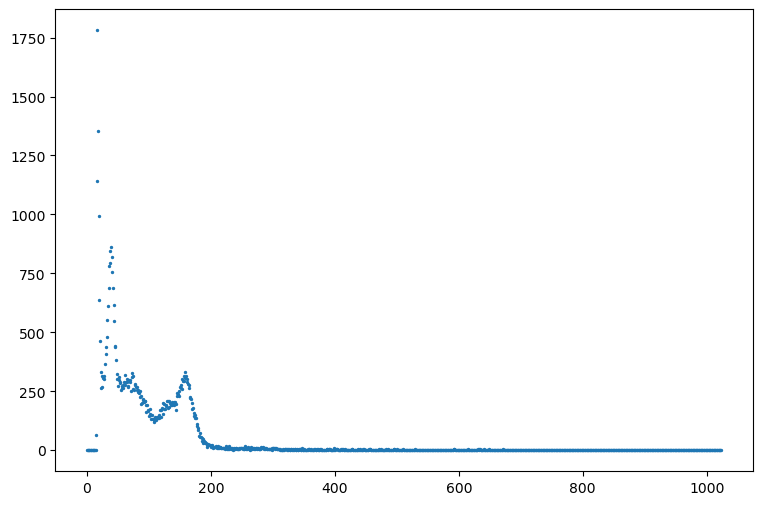

In [45]:
fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(spectrum_dict["bins"], spectrum_dict["counts"], s = 2)

In [46]:
background_header, background_spectrum = file_parser("experimental_NaI/Buffer_Data.Spe")

In [51]:
background_header

{'Keys': ['$SPEC_ID:',
  '$SPEC_REM:',
  '$DATE_MEA:',
  '$MEAS_TIM:',
  '$ROI:',
  '$PRESETS:',
  '$ENER_FIT:',
  '$MCA_CAL:',
  '$SHAPE_CAL:'],
 'Key Info': ['No sample description was entered.',
  'DET# 1',
  '10/21/2025 12:28:00',
  '136 136',
  '0',
  'None',
  '-10.130505 2.230151',
  '3',
  '3']}

In [57]:
#grabbing the count time from the header info

background_counttime = background_header["Key Info"][3].split(" ")
ba_counttime = header_dict["Key Info"][3].split(" ")

float(ba_counttime[0])

195.0

In [58]:
ba_ct = float(ba_counttime[0])
background_ct = float(background_counttime[0])

In [62]:
 np.array(background_spectrum["counts"])

array([0., 0., 0., ..., 0., 0., 0.])

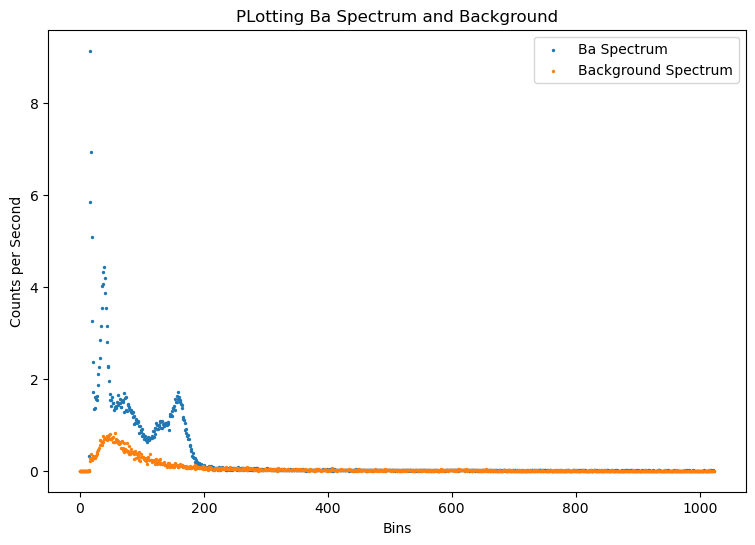

In [63]:
fig, ax = plt.subplots(figsize = (9, 6))
ax.set_title("PLotting Ba Spectrum and Background")
ax.set_xlabel("Bins")
ax.set_ylabel("Counts per Second")
ax.scatter(spectrum_dict["bins"], np.array(spectrum_dict["counts"]) / ba_ct, s = 2, label = ("Ba Spectrum"))

ax.scatter(background_spectrum["bins"], np.array(background_spectrum["counts"]) / background_ct, s = 2, label = ("Background Spectrum"))
ax.legend()

plt.show()

In [65]:
ba_background_subtracted = (np.array(spectrum_dict["counts"]) / ba_ct) - ( np.array(background_spectrum["counts"]) / background_ct)

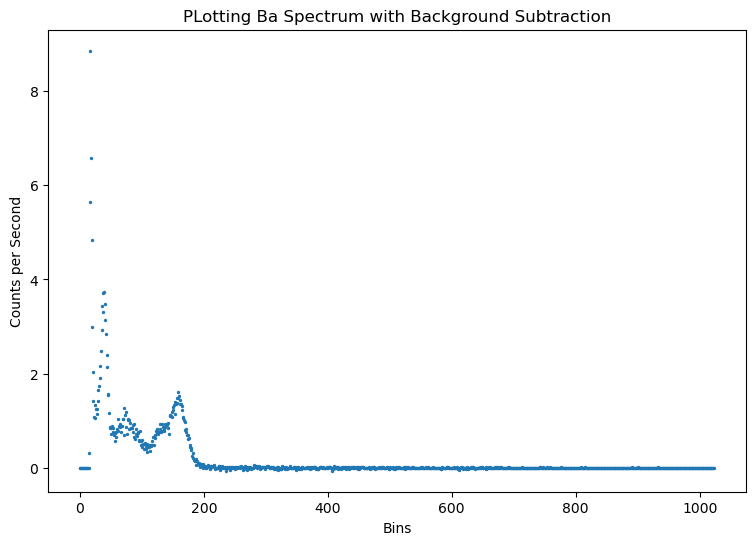

In [66]:
fig, ax = plt.subplots(figsize = (9, 6))
ax.set_title("PLotting Ba Spectrum with Background Subtraction")
ax.set_xlabel("Bins")
ax.set_ylabel("Counts per Second")
ax.scatter(spectrum_dict["bins"], ba_background_subtracted, s = 2, label = ("Ba Spectrum background sub"))

plt.show()

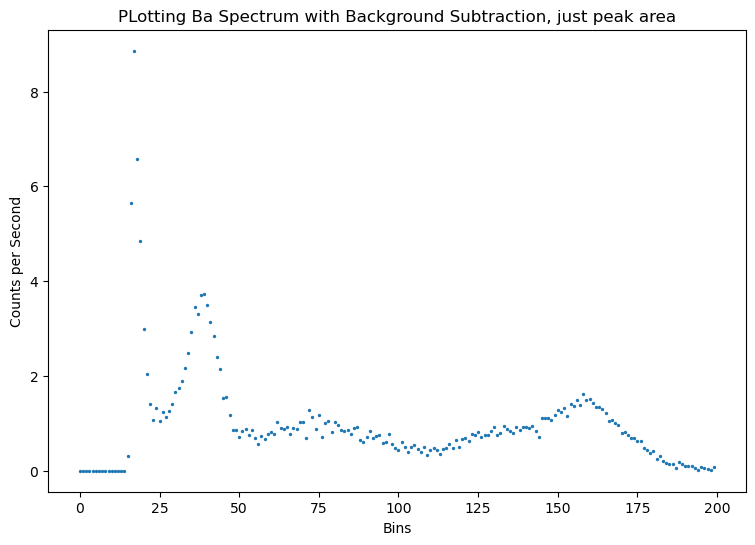

In [67]:
#cutting data to just look at where there are peaks: 

fig, ax = plt.subplots(figsize = (9, 6))
ax.set_title("PLotting Ba Spectrum with Background Subtraction, just peak area")
ax.set_xlabel("Bins")
ax.set_ylabel("Counts per Second")
ax.scatter(spectrum_dict["bins"][:200], ba_background_subtracted[:200], s = 2, label = ("Ba Spectrum background sub"))

plt.show()

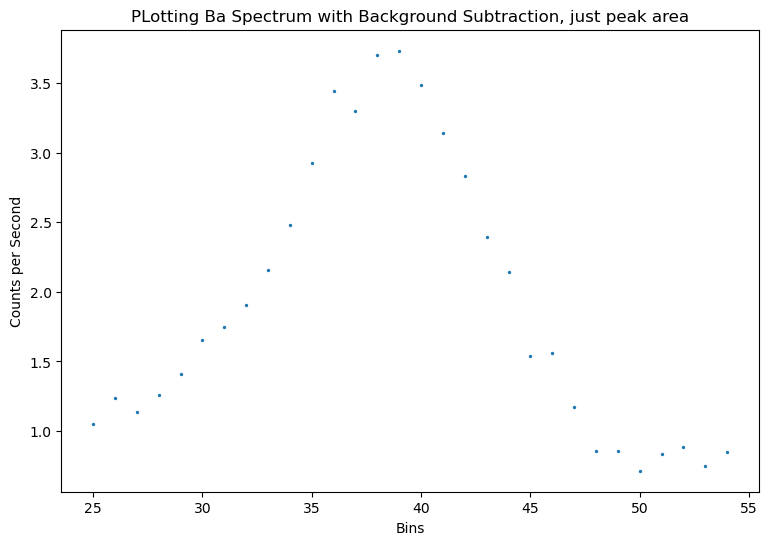

In [68]:
#cutting data to just look at where there are peaks: 

fig, ax = plt.subplots(figsize = (9, 6))
ax.set_title("PLotting Ba Spectrum with Background Subtraction, just peak area")
ax.set_xlabel("Bins")
ax.set_ylabel("Counts per Second")
ax.scatter(spectrum_dict["bins"][25:55], ba_background_subtracted[25:55], s = 2, label = ("Ba Spectrum background sub"))

plt.show()

In [99]:
# a bunch of gaussing fitting stuff from hw: 
#def ignore_peak(flux):
#    """
 #   Function used to ignore the peak part of the data for plotting the baseline
 #   Input: y data (flux)
#    Output: list of ajdusted y data, were values associated with the peak are replaced with mean flux
  #  """
 #   background_y = []
 #   mean_flux = np.mean(flux)
 #   flux_std = np.std(flux)
 #   for i in flux:
 #       if i > (mean_flux + 2.5 * flux_std): #if the flux is higher than this, the point is probably part of the peak
 #           background_y.append(mean_flux)
  #      else:
#            background_y.append(i)
 #   return background_y
    
#fitting functions: 
def quadratic(x, a, b, c):
    """A quatratic function, used for curve fitting"""
    return a * (x**2) + b * x + c

def gaussian(x, mu, sig, amp):
    """A Gaussian function, used for scipi curve fit"""
    return amp * np.exp(-0.5 * (x-mu)**2 / sig**2) / np.sqrt(2 * np.pi * sig**2)

def compound_model(x, mu, sig, amp, a, b, c):
    """combines the quadratic fit of the background with the Gaussian fit which better represents the peak"""
    return quadratic(x, a, b, c) + gaussian(x, mu, sig, amp)

def fit_compound_model(x, y, p0=None):
    """
    Function to fit data using curve_fit and compound_model
    Inputs: x, y (list of x, y data)
    Outputs: popt (parameters array), pcov (covarience array) 
    """

    #if no p0 is passed, guess: 

    if p0 is None: 
        A_guess = np.max(y) - np.min(y)
        mu_guess = np.sum(x * y) / np.sum(y)
        sigma_guess = (np.max(x) - np.min(x)) / 10
        #getting the polynomial parameters: 
        background_y = ignore_peak(y)
        b_popt, b_pcov = curve_fit(quadratic, x, background_y, p0 = None)

    p0 = [mu_guess, sigma_guess, A_guess, *b_popt]
    popt, pcov = curve_fit(compound_model, x, y, p0 = p0)

    return popt, pcov

def print_uncertainties(pcov, popt):
    """a function to print out the parameters and their uncertanties"""
    uncertainties = np.sqrt(np.diag(pcov))
    #[mu0, sig0, amp0, a, b, c] 
    print("Parameters: \n")
    print(f"Baseline Polynomial Fit: ")
    print(f"a = {popt[3]} +/- {uncertainties[3]},")
    print(f"b = {popt[4]} +/- {uncertainties[4]}, ")
    print(f"c = {popt[5]} +/- {uncertainties[5]}")
    print(f"Gaussian Fit: ")
    print(f"mu0 = {popt[0]} +/- {uncertainties[0]},")
    print(f"sigma0 = {popt[1]} +/- {uncertainties[1]},")
    print(f"amp0 = {popt[2]} +/- {uncertainties[2]}")

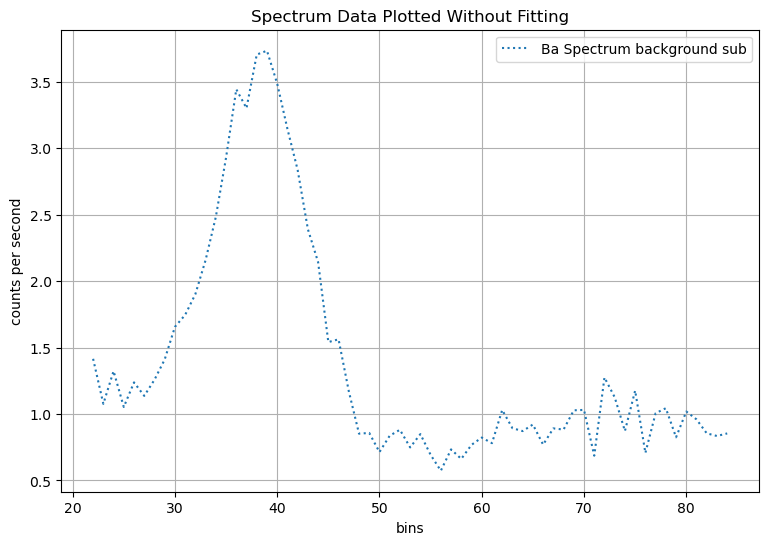

In [119]:
plt.close("all")
fig, ax = plt.subplots(figsize= (9, 6))
ax.set_title("Spectrum Data Plotted Without Fitting")
ax.set_xlabel("bins")
ax.set_ylabel("counts per second")

ax.plot(spectrum_dict["bins"][22:85], ba_background_subtracted[22:85], ls = ":", label = ("Ba Spectrum background sub"))
ax.grid()
ax.legend()

In [115]:
def ignore_peak(flux):
    """
    Function used to ignore the peak part of the data for plotting the baseline
    Input: y data (flux)
    Output: list of ajdusted y data, were values associated with the peak are replaced with mean flux
    """
    background_y = []
    mean_flux = np.mean(flux)
    flux_std = np.std(flux)
    for i in flux:
        if i > (1.5): #if the flux is higher than this, the point is probably part of the peak
            background_y.append(mean_flux)
        else:
            background_y.append(i)
    return background_y

In [120]:
#ignoring the flux for where theres a peak and instead setting the flux value to the mean
background_y = ignore_peak(ba_background_subtracted[22:85])
b_popt, b_pcov = curve_fit(quadratic, spectrum_dict["bins"][22:85], background_y, p0 = None)
quad_fit = quadratic(np.array(spectrum_dict["bins"][22:85]), *b_popt)

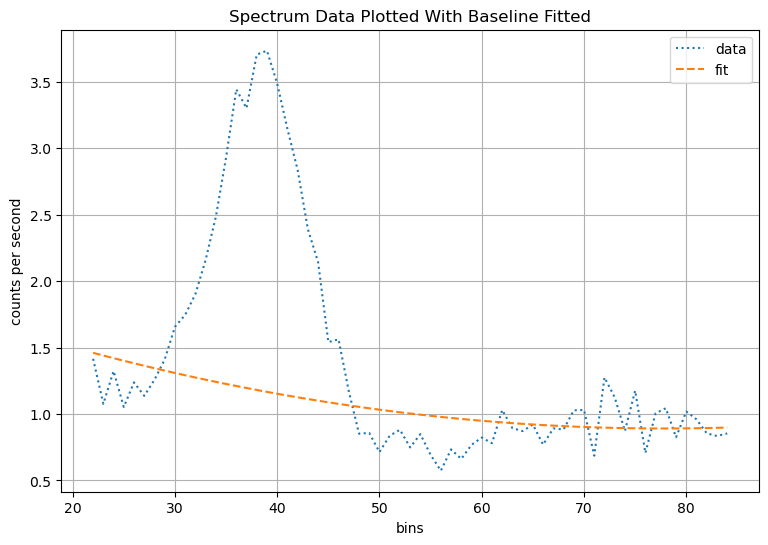

In [121]:
#plotting data with polynomial baseline fit overlaid:
fig, ax = plt.subplots(figsize  = (9,6))
ax.set_title("Spectrum Data Plotted With Baseline Fitted")
ax.set_xlabel("bins")
ax.set_ylabel("counts per second")

ax.plot(spectrum_dict["bins"][22:85], ba_background_subtracted[22:85], ls = ":", label = "data")
ax.plot(spectrum_dict["bins"][22:85], quad_fit, ls = '--', label = "fit")
ax.grid()
ax.legend()

Parameters: 

Baseline Polynomial Fit: 
a = 0.0003435366855055448 +/- 6.479695162108547e-05,
b = -0.039834235417051535 +/- 0.006864680031602071, 
c = 1.9625941814920913 +/- 0.1702796250847059
Gaussian Fit: 
mu0 = 38.42837650216463 +/- 0.12039027181235185,
sigma0 = -4.240078454013934 +/- 0.1391662691570418,
amp0 = 29.013230574426377 +/- 1.079673340912963


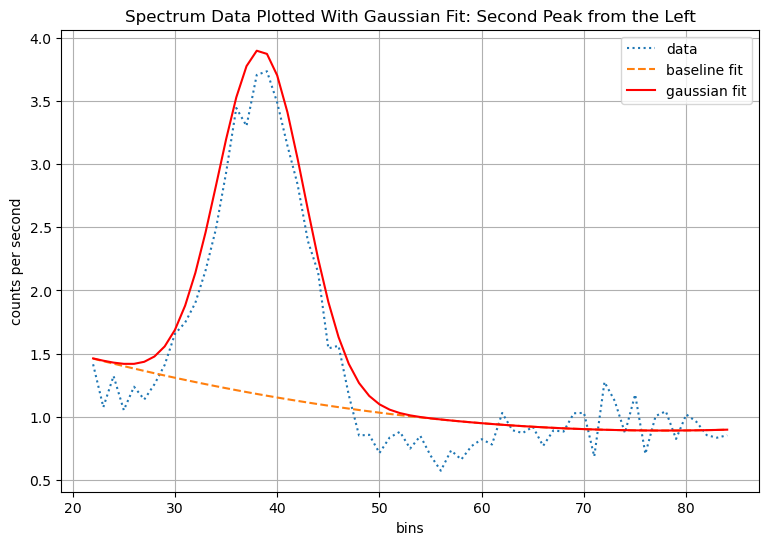

In [128]:
#fitting and plotting gauss model: 
popt, pcov = fit_compound_model(np.array(spectrum_dict["bins"][22:85]), np.array(ba_background_subtracted[22:85]))
#compound_fit = compound_model(np.array(spectrum_dict["Wavelength"]), *popt)
gauss_fit = gaussian(np.array(spectrum_dict["bins"][22:85]), *popt[:3])
    
fig, ax = plt.subplots(figsize = (9,6))

ax.set_title("Spectrum Data Plotted With Gaussian Fit: Second Peak from the Left")
ax.set_xlabel("bins")
ax.set_ylabel("counts per second")

ax.plot(spectrum_dict["bins"][22:85], ba_background_subtracted[22:85], ls = ":", label = "data")
ax.plot(spectrum_dict["bins"][22:85], quad_fit, ls = '--', label = "baseline fit")
#for some reason the line below works better than plotting compound model even though it should return the same thing?
ax.plot(spectrum_dict["bins"][22:85], gauss_fit + quad_fit, ls = '-', color = 'r', label = "gaussian fit") 
ax.grid()
ax.legend()

#printing out parameters and uncertainties:
print_uncertainties(pcov, popt)

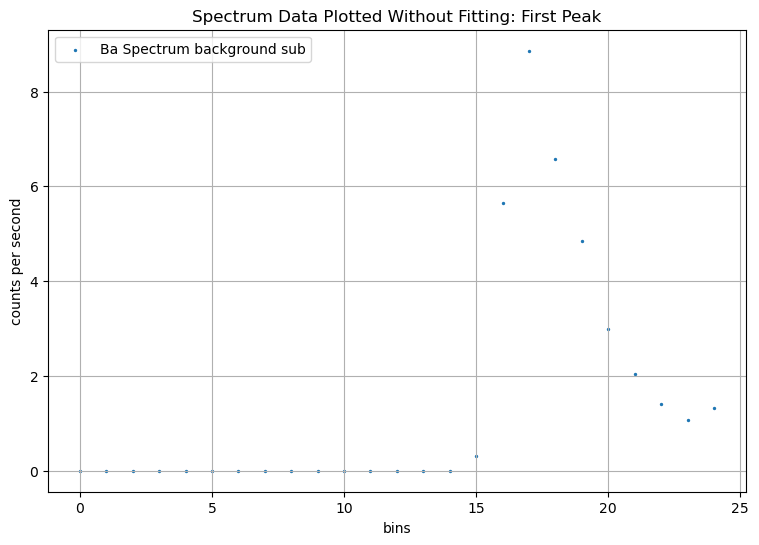

In [129]:
#doing the same thing again with the peak earlier:

plt.close("all")
fig, ax = plt.subplots(figsize= (9, 6))
ax.set_title("Spectrum Data Plotted Without Fitting: First Peak")
ax.set_xlabel("bins")
ax.set_ylabel("counts per second")

ax.scatter(spectrum_dict["bins"][0:25], ba_background_subtracted[0:25], s = 2, label = ("Ba Spectrum background sub"))
ax.grid()
ax.legend()